In [1021]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nqDataLoader as nq #data loading library
from MFDFA import MFDFA
from MFDFA import singspect

In [1022]:
def range_with_floats(start, stop, step):
    while stop > start:
        yield start
        start += step

In [1023]:
def is_outlier(value, p25, p75):
    """Check if value is an outlier
    """
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return value <= lower or value >= upper

## importing the early_stage data set 

In [1024]:
## importing the early stage dataset 
early_stage = pd.read_csv('GT_DataPD_MIT-CS2PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
early_stage.head()

,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1
0,1000,True,27,79.0,184.5,0.107179,56.866667,1424946827.1000_001_014.csv
1,1001,True,16,96.5,189.0,0.056286,118.000000,1427279751.1001_001_014.csv
2,1002,False,5,140.0,158.0,0.039519,119.037037,1426676689.1002_001_014.csv
3,1004,True,22,83.5,191.5,0.034853,74.266667,1429866367.1004_001_014.csv
4,1005,True,17,68.0,150.0,0.048307,74.969697,1430134526.1005_001_014.csv


## Calculating the SDI for early stage dataset 

In [1025]:
SD_index = []
for index, row in early_stage.iterrows():
    fileloc = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( "data_MIT-CS2PD/" + early_stage.loc[index]['file_1'])
    fluctuations = []
    for i in range(0,len(htArr)-1):
        row1 = htArr[i]
        row2 = htArr[i+1]
        temp1 = np.log(row1)
        temp2 = np.log(row2)
        result = temp2-temp1
        fluctuations.append(result)
    npFluctuations = np.array(fluctuations)
    sd_index_score = npFluctuations.std()
    SD_index.append(sd_index_score) 
    
    
early_stage["SDi"] = SD_index 

In [1026]:
delta_alphas = []
for index, row in early_stage.iterrows():
    fileloc = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( "data_MIT-CS2PD/" + early_stage.loc[index]['file_1'])
    npHtArr = np.array(htArr)
    #100lagspointsfrom3to1000
    lag=np.logspace(1,2,300).astype(int)
    lag=np.unique(lag)
    #qpowervariations,removing0power
    q=np.linspace(-3,3,61)
    q=q[q!=0.0]
    lag,fluct=MFDFA(npHtArr,lag=lag,q=q)
    alpha,f = singspect.singularity_spectrum(lag,fluct,q)
    delta_alphas.append(alpha.max()-alpha.min())
    
    

print(np.mean(delta_alphas))
early_stage['singularity_spectrum_wdith'] = delta_alphas
early_stage_sick =early_stage[early_stage['gt']==1]
print(early_stage_sick['singularity_spectrum_wdith'].mean())

0.27605838340722066
0.3229097295803529


In [1027]:
print(np.logspace(1,2,118).astype(int))

[ 10  10  10  10  10  11  11  11  11  11  12  12  12  12  13  13  13  13
  14  14  14  15  15  15  16  16  16  17  17  17  18  18  18  19  19  19
  20  20  21  21  21  22  22  23  23  24  24  25  25  26  26  27  27  28
  28  29  30  30  31  31  32  33  33  34  35  35  36  37  38  38  39  40
  41  42  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  61  62  63  64  66  67  68  70  71  72  74  75  77  78  80  82
  83  85  87  88  90  92  94  96  98 100]


In [1028]:
SD_index = []
outlier_count = []
for index, row in early_stage.iterrows():
    fileloc = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( "data_MIT-CS2PD/" + early_stage.loc[index]['file_1'])
    fluctuations = []
    for i in range(0,len(htArr)-1):
        row1 = htArr[i]
        row2 = htArr[i+1]
        temp1 = np.log(row1)
        temp2 = np.log(row2)
        result = temp2-temp1
        fluctuations.append(result)
    npFluctuations = np.array(fluctuations)
    ## getting outlier count 
    nphtArr = np.array(htArr)
    outliers = []
    p25 = np.percentile(nphtArr, 25)
    p75 = np.percentile(nphtArr, 75)
    for ind, value in enumerate(nphtArr):
        if is_outlier(value, p25, p75):
            outliers.append(value) 
    
    sd_index_score = npFluctuations.std()
    SD_index.append(sd_index_score)
    npoutliers = np.array(outliers)
    outlier_count.append(len(npoutliers))
    
    
early_stage["SDi"] = SD_index
early_stage['htArrOutliers'] = outlier_count

In [1029]:
dexterityMetric = []
for index, row in early_stage.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS2PD/' + early_stage.loc[index]['file_1'])
    
    dexterity = []
    for i in range(0,len(keyPressed)-1):
        d1 = releaseArr[i]
        p2 = pressArr[i+1]
        result = 0 if (d1-p2 < 0) else (d1-p2)
        dexterity.append(result)
    npdexterity = np.array(dexterity)
    dexterityMetric.append(npdexterity.std())
    

early_stage["Dexterity"] = dexterityMetric

In [1030]:
InterQuartileRanges =[]
for index,row in early_stage.iterrows():
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS2PD/' + early_stage.loc[index]['file_1'])
    nphtArr = np.array(htArr)
    q3, q1 = np.percentile(htArr, [75 ,25])
    iqr = q3 - q1
    InterQuartileRanges.append(iqr)
early_stage["InterQuartileRanges"] = InterQuartileRanges

In [1031]:
Hist1 =[]
Hist2 = []
Hist3 =[]
Hist4 = []
for index,row in early_stage.iterrows():
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS2PD/' + early_stage.loc[index]['file_1'])
    Histogram = np.histogram(htArr,bins = 4)
    Hist1.append(Histogram[0][0])
    Hist2.append(Histogram[0][1])
    Hist3.append(Histogram[0][2])
    Hist4.append(Histogram[0][3])
    
early_stage["Hist1"] = Hist1
early_stage["Hist2"] = Hist2
early_stage["Hist3"] = Hist3
early_stage["Hist4"] = Hist4

## preparing the dataset to only have SDi as a feature and the gt as the dependant variable

In [1032]:
early_stage["gt"] = early_stage["gt"].astype(int)
early_stage_features = early_stage[['SDi','afTap','Dexterity','InterQuartileRanges','gt']]
early_stage_features = early_stage[['SDi','afTap','Dexterity','InterQuartileRanges','Hist1','Hist2','Hist3','Hist4','gt']]
early_stage_features = early_stage[['SDi','Dexterity','InterQuartileRanges','htArrOutliers','Hist1','Hist2','Hist3','Hist4','singularity_spectrum_wdith','gt']]
print(len(early_stage))
early_stage.head()


54


,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,SDi,singularity_spectrum_wdith,htArrOutliers,Dexterity,InterQuartileRanges,Hist1,Hist2,Hist3,Hist4
0,1000,1,27,79.0,184.5,0.107179,56.866667,1424946827.1000_001_014.csv,0.380584,0.671041,28,0.001368,0.050800,847,7,0,1
1,1001,1,16,96.5,189.0,0.056286,118.000000,1427279751.1001_001_014.csv,0.378429,0.454651,50,0.021848,0.036200,1567,25,0,1
2,1002,0,5,140.0,158.0,0.039519,119.037037,1426676689.1002_001_014.csv,0.349012,0.171950,86,0.000713,0.021000,1565,41,0,1
3,1004,1,22,83.5,191.5,0.034853,74.266667,1429866367.1004_001_014.csv,0.354817,0.087694,8,0.000000,0.045775,581,515,17,1
4,1005,1,17,68.0,150.0,0.048307,74.969697,1430134526.1005_001_014.csv,0.236304,0.255949,43,0.001078,0.020200,55,955,212,15


## importing the de_novo dataset

In [1033]:
## importing the de-novo dataset 
de_novo = pd.read_csv('GT_DataPD_MIT-CS1PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
print(len(de_novo))
de_novo.head()

31


,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2
0,11,True,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv
1,60,False,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv
2,67,True,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv
3,68,False,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv
4,70,True,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv


## calculating the SDi for the de_novo dataset 

In [1034]:
##using both files 
SD_index = []
for index, row in de_novo.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    
    fluctuations = []
    for i in range(0,len(htArr)-1):
        row1 = htArr[i]
        row2 = htArr[i+1]
        temp1 = np.log(row1)
        temp2 = np.log(row2)
        result = temp2-temp1
        fluctuations.append(result)
    
    fileloc2 = row.file_2
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    for i in range(0,len(htArr)-1):
        row1 = htArr[i]
        row2 = htArr[i+1]
        temp1 = np.log(row1)
        temp2 = np.log(row2)
        result = temp2-temp1
        fluctuations.append(result)
        
    npFluctuations = np.array(fluctuations)
    sd_index_score = npFluctuations.std()
    SD_index.append(sd_index_score) 
    
    
de_novo["SDi"] = SD_index 
de_novo.head()

,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2,SDi
0,11,True,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv,0.564521
1,60,False,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv,0.421491
2,67,True,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv,0.448163
3,68,False,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv,0.229087
4,70,True,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv,0.319824


In [1035]:
##using both files 
delta_alphas = []
for index, row in de_novo.iterrows():
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1']) 
    keyPressed2, htArr2, pressArr2, releaseArr2 =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    htArr = [*htArr,*htArr2]
    npHtArr = np.array(htArr)
    #100lagspointsfrom3to1000
    lag=np.logspace(1,2,300).astype(int)
    lag=np.unique(lag)
    #qpowervariations,removing0power
    q=np.linspace(-3,3,61)
    q=q[q!=0.0]
    lag,fluct=MFDFA(npHtArr,lag=lag,q=q)
    alpha,f = singspect.singularity_spectrum(lag,fluct,q)
    delta_alphas.append(alpha.max()-alpha.min())
   
    
    
de_novo["singularity_spectrum_wdith"] = delta_alphas


In [1036]:
dexterityMetric = []
for index, row in de_novo.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    
    dexterity = []
    for i in range(0,len(keyPressed)-1):
        d1 = releaseArr[i]
        p2 = pressArr[i+1]
        result = 0 if (d1-p2 < 0) else (d1-p2)
        dexterity.append(result)
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    htArrFirst = htArr[0]
    fluctuations.append(result)
    for i in range(1,len(keyPressed)-1):
        d1 = releaseArr[i]
        p2 = pressArr[i+1]
        result = 0 if (d1-p2 < 0) else (d1-p2)
        dexterity.append(result)
    npdexterity = np.array(dexterity)
    dexterityMetric.append(npdexterity.std())
    

de_novo["Dexterity"] = dexterityMetric

In [1037]:
InterQuartileRanges =[]
for index,row in de_novo.iterrows():
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    
    
    
    keyPressed, htArr2, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    npdata = np.append(htArr,htArr2,axis = 0 )
        
    q3, q1 = np.percentile(npdata, [75 ,25])
    iqr = q3 - q1
    InterQuartileRanges.append(iqr)
de_novo["InterQuartileRanges"] = InterQuartileRanges

In [1038]:
Variances =[]
for index,row in de_novo.iterrows():
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    
    
    
    keyPressed, htArr2, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    npdata = np.append(htArr,htArr2,axis = 0 )
    Variances.append(np.var(npdata))
de_novo["Variance"] = Variances

In [1039]:
Hist1 =[]
Hist2 = []
Hist3 =[]
Hist4 = []
for index,row in de_novo.iterrows():
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    
    
    
    keyPressed, htArr2, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    npdata = np.append(htArr,htArr2,axis = 0 )
    Histogram = np.histogram(npdata,bins =4)
    Hist1.append(Histogram[0][0])
    Hist2.append(Histogram[0][1])
    Hist3.append(Histogram[0][2])
    Hist4.append(Histogram[0][3])
    
de_novo["Hist1"] = Hist1
de_novo["Hist2"] = Hist2
de_novo["Hist3"] = Hist3
de_novo["Hist4"] = Hist4

In [1040]:
##using both files 
SD_index = []
outlier_count = []
for index, row in de_novo.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    nphtArr = np.array(htArr)
    ##fiinding outliers
    outliers = []
    p25 = np.percentile(nphtArr, 25)
    p75 = np.percentile(nphtArr, 75)
    for ind, value in enumerate(nphtArr):
        if is_outlier(value, p25, p75):
            outliers.append(value) 
    fluctuations = []
    for i in range(0,len(htArr)-1):
        row1 = htArr[i]
        row2 = htArr[i+1]
        temp1 = np.log(row1)
        temp2 = np.log(row2)
        result = temp2-temp1
        fluctuations.append(result)
    
    fileloc2 = row.file_2
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    nphtArr = np.array(htArr)
    p25 = np.percentile(nphtArr, 25)
    p75 = np.percentile(nphtArr, 75)
    for ind, value in enumerate(nphtArr):
        if is_outlier(value, p25, p75):
            outliers.append(value) 
    for i in range(0,len(htArr)-1):
        row1 = htArr[i]
        row2 = htArr[i+1]
        temp1 = np.log(row1)
        temp2 = np.log(row2)
        result = temp2-temp1
        fluctuations.append(result)  
    npFluctuations = np.array(fluctuations)
    sd_index_score = npFluctuations.std()
    SD_index.append(sd_index_score)
    npoutliers = np.array(outliers)
    outlier_count.append(len(npoutliers))
    
de_novo["SDi"] = SD_index
de_novo['htArrOutliers'] = outlier_count
de_novo.head()

,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2,SDi,singularity_spectrum_wdith,Dexterity,InterQuartileRanges,Variance,Hist1,Hist2,Hist3,Hist4,htArrOutliers
0,11,True,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv,0.564521,0.395982,0.012277,0.052500,0.002587,4816,9,3,1,168
1,60,False,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv,0.421491,0.289706,0.001475,0.049800,0.001659,1791,27,2,1,26
2,67,True,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv,0.448163,0.517114,0.002181,0.108200,0.005904,339,893,354,45,19
3,68,False,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv,0.229087,0.120067,0.000000,0.032000,0.000640,898,1178,74,6,27
4,70,True,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv,0.319824,0.058468,0.000000,0.053925,0.001793,116,739,267,28,28


## trimming the de_novo dataset to contain only the SDi as a feature and the gt as the target variable 

In [1041]:
de_novo["gt"] = de_novo["gt"].astype(int)

de_novo_features = de_novo[['SDi','afTap','Dexterity','InterQuartileRanges','Variance','gt']]
de_novo_features =de_novo[['SDi','afTap','Dexterity','InterQuartileRanges','gt']]
de_novo_features =de_novo[['SDi','afTap','Dexterity','InterQuartileRanges','Hist1','Hist2','Hist3','Hist4','gt']]
de_novo_features =de_novo[['SDi','Dexterity','InterQuartileRanges','Hist1','htArrOutliers','Hist2','Hist3','Hist4','singularity_spectrum_wdith','gt']]
de_novo.head()

,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2,SDi,singularity_spectrum_wdith,Dexterity,InterQuartileRanges,Variance,Hist1,Hist2,Hist3,Hist4,htArrOutliers
0,11,1,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv,0.564521,0.395982,0.012277,0.052500,0.002587,4816,9,3,1,168
1,60,0,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv,0.421491,0.289706,0.001475,0.049800,0.001659,1791,27,2,1,26
2,67,1,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv,0.448163,0.517114,0.002181,0.108200,0.005904,339,893,354,45,19
3,68,0,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv,0.229087,0.120067,0.000000,0.032000,0.000640,898,1178,74,6,27
4,70,1,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv,0.319824,0.058468,0.000000,0.053925,0.001793,116,739,267,28,28


## splitting the de_novo patients to double the dataset size by considering file_2 of a patient a different 

## appending the datasets together

In [1042]:
print(len(early_stage))
print(len(de_novo))
Xy = early_stage_features.append(de_novo_features, ignore_index=True)
print(len(early_stage))


54
31
54


C:\Users\micoa\AppData\Local\Temp\ipykernel_15784\838164722.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Xy = early_stage_features.append(de_novo_features, ignore_index=True)


In [1043]:
print(Xy.corr())

                                 SDi  Dexterity  InterQuartileRanges  \
SDi                         1.000000   0.295935             0.762871   
Dexterity                   0.295935   1.000000             0.290355   
InterQuartileRanges         0.762871   0.290355             1.000000   
htArrOutliers              -0.009785   0.088081            -0.290704   
Hist1                       0.272853   0.449161             0.086268   
Hist2                      -0.162418   0.136585            -0.124963   
Hist3                       0.110829  -0.119831             0.016193   
Hist4                       0.131300  -0.134196             0.029702   
singularity_spectrum_wdith  0.132203   0.133350             0.047590   
gt                          0.443386   0.275469             0.477395   

                            htArrOutliers     Hist1     Hist2     Hist3  \
SDi                             -0.009785  0.272853 -0.162418  0.110829   
Dexterity                        0.088081  0.449161  0.13

In [1044]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
cat, num = "gt", "singularity_spectrum_wdith"
model = smf.ols(num+' ~ '+cat, data=Xy).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Non-Correlated (p-value: 0.054)


In [1045]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
cat, num = "gt", "afTap"
model = smf.ols(num+' ~ '+cat, data=early_stage).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


## splitting the data into features and dependant variable and further splitting into train and testing data

In [1046]:

X = Xy.iloc[:, :-1].values
y = Xy.iloc[:, -1].values

In [1047]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
def testClassifierRaw(classifier,X,y):
    pipe = Pipeline([('scaler', StandardScaler()), ('classifer', classifier)])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)
    pipe.fit(X_train,y_train)
    y_pred =  pipe.predict(X_test)
    titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            pipe,
            X_test,
            y_test,
            display_labels=None ,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    print("Accuracy score : " + str(accuracy_score(y_test, y_pred,  normalize=True, sample_weight=None)))
    X = np.concatenate((X_train, X_test), axis=0) 
    y = np.concatenate((y_train, y_test), axis=0)
    scores = cross_val_score(pipe,X,y,cv=5)
    print("Mean accuracy of 5 fold cross validation test : "+ str(scores.mean()))
    print("with a maximum accuracy of " + str(scores.max()))
    scores = cross_val_score(pipe,X,y,cv=10)
    print("Mean accuracy of 10 fold cross validation test : "+ str(scores.mean()))
    print("with a maximum accuracy of " + str(scores.max()))
    scores = cross_val_score(pipe,X,y,cv=KFold(85))
    print("Mean accuracy of n fold cross validation test : "+ str(scores.mean()))
    print("with a maximum accuracy of " + str(scores.max()))
    scores = cross_val_score(pipe,X,y,cv=KFold())
    print("Mean accuracy of n fold cross validation test : "+ str(scores.mean()))
    print("with a maximum accuracy of " + str(scores.max()))

In [1048]:
from sklearn import impute
from numpy.ma.core import mean
#filling missing data with the average of the data around it 
from sklearn.impute import SimpleImputer
imputer  = SimpleImputer(missing_values=np.nan, strategy="mean")
# imputer.fit(x[:,1:3])
# x[:,1:3] = imputer.transform(x[:,1:3])
#combines the two lines into one 
X[:,:-1] = imputer.fit_transform(X[:,:-1])
print(X)

[[3.80584214e-01 1.36823497e-03 5.08000000e-02 2.80000000e+01
  8.47000000e+02 7.00000000e+00 0.00000000e+00 1.00000000e+00
  6.71040577e-01]
 [3.78428780e-01 2.18476127e-02 3.62000000e-02 5.00000000e+01
  1.56700000e+03 2.50000000e+01 0.00000000e+00 1.00000000e+00
  4.54650866e-01]
 [3.49012031e-01 7.12569236e-04 2.10000000e-02 8.60000000e+01
  1.56500000e+03 4.10000000e+01 0.00000000e+00 1.00000000e+00
  1.71950473e-01]
 [3.54816649e-01 0.00000000e+00 4.57750000e-02 8.00000000e+00
  5.81000000e+02 5.15000000e+02 1.70000000e+01 1.00000000e+00
  8.76935444e-02]
 [2.36303990e-01 1.07759165e-03 2.02000000e-02 4.30000000e+01
  5.50000000e+01 9.55000000e+02 2.12000000e+02 1.50000000e+01
  2.55948976e-01]
 [4.30975746e-01 6.77585959e-03 3.48000000e-02 4.20000000e+01
  8.37000000e+02 4.59000000e+02 6.60000000e+01 1.20000000e+01
  2.83575610e-01]
 [5.85703902e-01 1.25543177e-02 7.22000000e-02 1.30000000e+01
  1.26000000e+03 6.03000000e+02 2.98000000e+02 3.10000000e+01
  6.10817694e-01]
 [3.66

In [1049]:
# from sklearn.decomposition import PCA
# pca = PCA(1)
# principalComponents = pca.fit_transform(X)
# print(pca.n_components_)
# print(np.array(X).shape)


In [1050]:
np.corrcoef(X[0], X[1])

array([[1.        , 0.99996725],
       [0.99996725, 1.        ]])

In [1051]:
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# dataframe = X
# dataframe[2]=y
# dataframe['SDi','afTap'] = sc.fit_transform(X)
# cov = np.cov(dataframe.T, bias=True)
# labs = ['SDi', 'afTap']
# sns.heatmap(cov, annot=True, fmt='g', xticklabels=labs, yticklabels=labs)
# print(np.shape(cov))

In [1052]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)

In [1053]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test =  sc.transform(X_test)

In [1054]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
principalComponents = pca.fit_transform(X_train)
print(pca.n_components_)
print(np.array(X).shape)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

9
(85, 9)


In [1055]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [1056]:
y_pred =  classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))
print(len(y_pred))

[[1 0]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]]
17


Confusion matrix, without normalization
[[6 3]
 [3 5]]
Normalized confusion matrix
[[0.66666667 0.33333333]
 [0.375      0.625     ]]


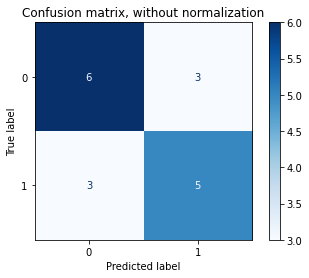

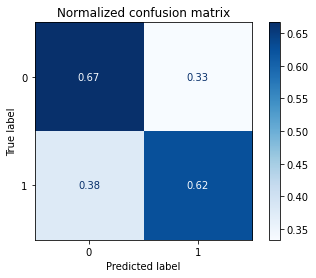

Accuracy score : 0.6470588235294118


In [1057]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=None ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
print("Accuracy score : " + str(accuracy_score(y_test, y_pred,  normalize=True, sample_weight=None)))

In [1058]:
# from matplotlib.colors import ListedColormap
# X_set, y_set = sc.inverse_transform(X_train), y_train
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() -0.1 , stop = X_set[:, 0].max() + 0.1 , step = 0.001),
#                      np.arange(start = X_set[:, 1].min() - 10, stop = X_set[:, 1].max() + 10, step = 0.001))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Logistic regression  (Training set)')
# plt.xlabel('SDi')
# plt.ylabel('afTap')
# plt.legend()
# plt.show()

In [1059]:
# from matplotlib.colors import ListedColormap
# X_set, y_set = sc.inverse_transform(X_test), y_test
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0.1, stop = X_set[:, 0].max() + 0.1, step = 0.001),
#                      np.arange(start = X_set[:, 1].min() - 10, stop = X_set[:, 1].max() + 10, step = 0.001))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Logistic Regression  (Test set)')
# plt.xlabel('SDi')
# plt.ylabel('afTap')
# plt.legend()
# plt.show()

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


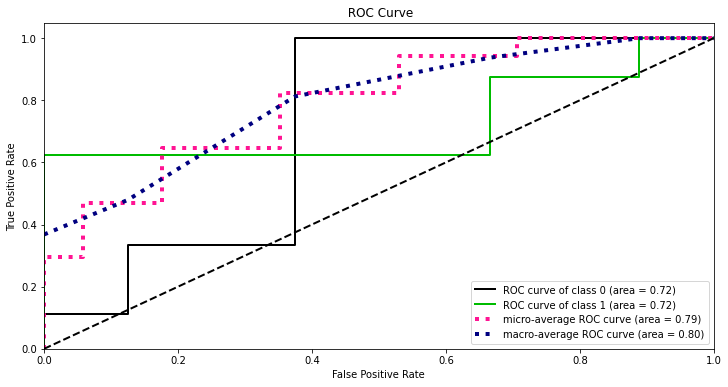

In [1060]:
import scikitplot as skplt
Y_test_probs = classifier.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, Y_test_probs,
                       title=" ROC Curve", figsize=(12,6));

## attempting to use K-neighrest neighbour 

In [1061]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [1062]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]]


Confusion matrix, without normalization
[[8 1]
 [3 5]]
Normalized confusion matrix
[[0.88888889 0.11111111]
 [0.375      0.625     ]]


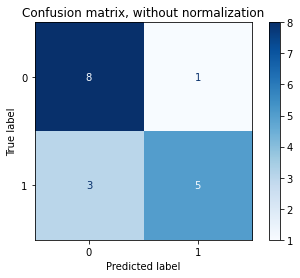

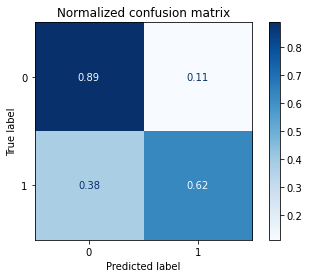

Accuracy Score : 0.7647058823529411


In [1063]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=None ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
print("Accuracy Score : " + str(accuracy_score(y_test, y_pred,  normalize=True, sample_weight=None)))

In [1064]:
# from matplotlib.colors import ListedColormap
# X_set, y_set = sc.inverse_transform(X_train), y_train
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0.1, stop = X_set[:, 0].max() + 0.1, step = 0.001),
#                      np.arange(start = X_set[:, 1].min() - 10, stop = X_set[:, 1].max() + 10, step = 0.001))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('K-NN  (Training set)')
# plt.xlabel('SDi')
# plt.ylabel('afTap')
# plt.legend()
# plt.show()

In [1065]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state=0,probability=True)
classifier.fit(X_train,y_train)

SVC(probability=True, random_state=0)

In [1066]:
y_pred =  classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]]


Confusion matrix, without normalization
[[9 0]
 [3 5]]
Normalized confusion matrix
[[1.    0.   ]
 [0.375 0.625]]


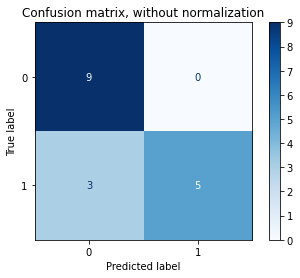

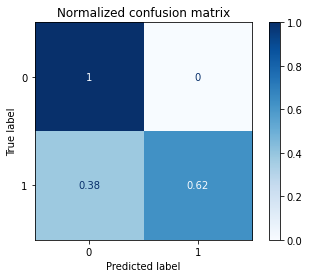

Accuracy score : 0.8235294117647058


In [1067]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=None ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
print("Accuracy score : " + str(accuracy_score(y_test, y_pred,  normalize=True, sample_weight=None)))

In [1068]:
# from matplotlib.colors import ListedColormap
# X_set, y_set = sc.inverse_transform(X_train), y_train
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0.1, stop = X_set[:, 0].max() + 0.1, step = 0.001),
#                      np.arange(start = X_set[:, 1].min() - 10, stop = X_set[:, 1].max() + 10, step = 0.001))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('SVC rbf kernel  (Training set)')
# plt.xlabel('SDi')
# plt.ylabel('afTap')
# plt.legend()
# plt.show()

In [1069]:
# from matplotlib.colors import ListedColormap
# X_set, y_set = sc.inverse_transform(X_test), y_test
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0.1, stop = X_set[:, 0].max() + 0.1, step = 0.001),
#                      np.arange(start = X_set[:, 1].min() - 10, stop = X_set[:, 1].max() + 10, step = 0.001))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('SVC rbf kernel (Test set)')
# plt.xlabel('SDi')
# plt.ylabel(' afTap')
# plt.legend()
# plt.show()

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


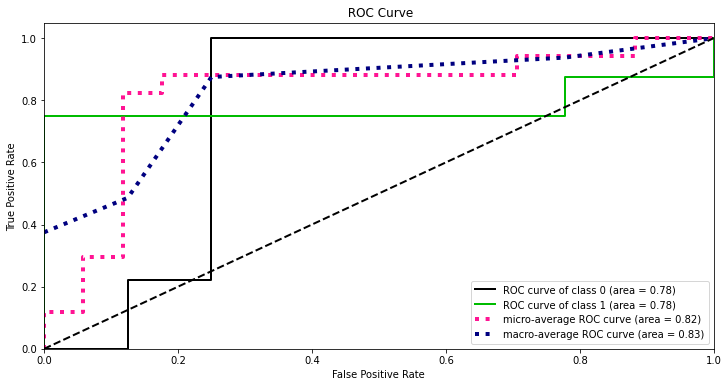

In [1070]:
import scikitplot as skplt
Y_test_probs = classifier.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, Y_test_probs,
                       title=" ROC Curve", figsize=(12,6));

In [1071]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train,y_train)

GaussianNB()

In [1072]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]]


Confusion matrix, without normalization
[[9 0]
 [2 6]]
Normalized confusion matrix
[[1.   0.  ]
 [0.25 0.75]]


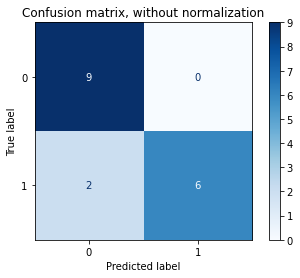

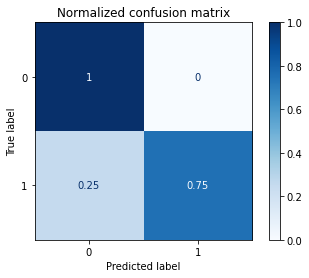

Accuracy score : 0.8823529411764706


In [1073]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=None ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
print("Accuracy score : " + str(accuracy_score(y_test, y_pred,  normalize=True, sample_weight=None)))

In [1074]:
# from matplotlib.colors import ListedColormap
# X_set, y_set = sc.inverse_transform(X_train), y_train
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0.1, stop = X_set[:, 0].max() + 0.1, step = 0.001),
#                      np.arange(start = X_set[:, 1].min() - 10, stop = X_set[:, 1].max() + 10, step = 0.001))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Naive Bayes (Training set)')
# plt.xlabel('Age')
# plt.ylabel('Estimated Salary')
# plt.legend()
# plt.show()

In [1075]:
# from matplotlib.colors import ListedColormap
# X_set, y_set = sc.inverse_transform(X_test), y_test
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0.1, stop = X_set[:, 0].max() + 0.1, step = 0.001),
#                      np.arange(start = X_set[:, 1].min() - 10, stop = X_set[:, 1].max() + 10, step = 0.001))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Naive Bayes (Test set)')
# plt.xlabel('Age')
# plt.ylabel('Estimated Salary')
# plt.legend()
# plt.show()

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


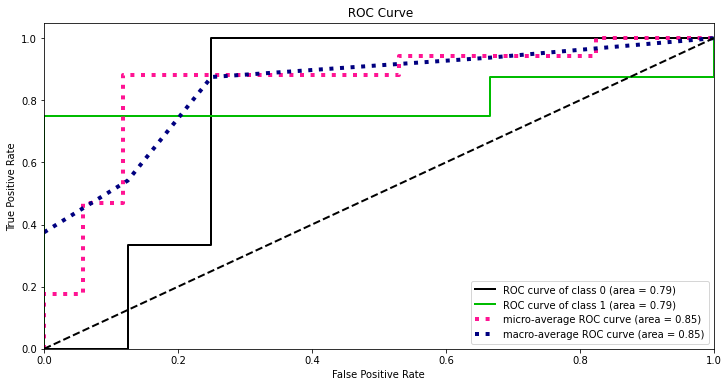

In [1076]:
import scikitplot as skplt
Y_test_probs = classifier.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, Y_test_probs,
                       title=" ROC Curve", figsize=(12,6));

In [1077]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 6, criterion = 'entropy')
classifier.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=6)

In [1078]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 0]
 [1 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]]


Confusion matrix, without normalization
[[6 3]
 [4 4]]
Normalized confusion matrix
[[0.66666667 0.33333333]
 [0.5        0.5       ]]


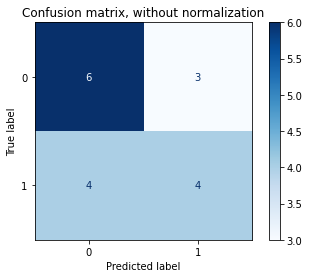

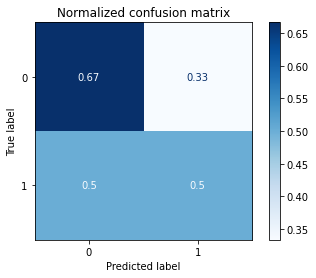

Accuracy score : 0.5882352941176471


In [1079]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=None ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
print("Accuracy score : " + str(accuracy_score(y_test, y_pred,  normalize=True, sample_weight=None)))

In [1080]:
# from matplotlib.colors import ListedColormap
# X_set, y_set = sc.inverse_transform(X_train), y_train
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0.1, stop = X_set[:, 0].max() + 0.1, step = 0.001),
#                      np.arange(start = X_set[:, 1].min() - 10, stop = X_set[:, 1].max() + 10, step = 0.001))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Ranom forest ensemlbed classifier  (Training set)')
# plt.xlabel('Age')
# plt.ylabel('Estimated Salary')
# plt.legend()
# plt.show()

In [1081]:
# from matplotlib.colors import ListedColormap
# X_set, y_set = sc.inverse_transform(X_test), y_test
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0.1, stop = X_set[:, 0].max() + 0.1, step = 0.001),
#                      np.arange(start = X_set[:, 1].min() - 10, stop = X_set[:, 1].max() + 10, step = 0.001))
# plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Naive Bayes (Test set)')
# plt.xlabel('Age')
# plt.ylabel('Estimated Salary')
# plt.legend()
# plt.show()

In [1082]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
svc = SVC()
classifier = BaggingClassifier(base_estimator=svc , n_estimators=100)
classifier.fit(X_train,y_train)

BaggingClassifier(base_estimator=SVC(), n_estimators=100)

In [1083]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]]


Confusion matrix, without normalization
[[8 1]
 [3 5]]
Normalized confusion matrix
[[0.88888889 0.11111111]
 [0.375      0.625     ]]


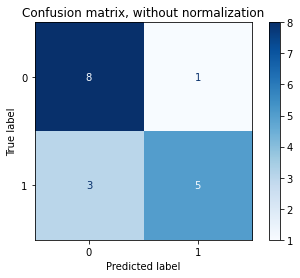

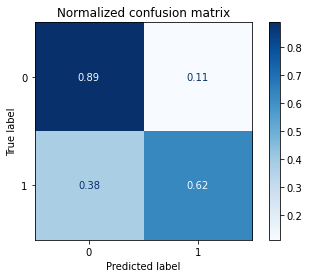

Accuracy score : 0.7647058823529411


In [1084]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=None ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
print("Accuracy score : " + str(accuracy_score(y_test, y_pred,  normalize=True, sample_weight=None)))

In [1085]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

scores = cross_val_score(DecisionTreeClassifier(),X,y,cv=10)
scores.mean()

0.6444444444444445

In [1086]:
from sklearn.ensemble import BaggingClassifier
bag_model = BaggingClassifier(
base_estimator = DecisionTreeClassifier(),
n_estimators = 5,
max_samples = 0.7,
oob_score=True,
)
scores = cross_val_score(bag_model,X,y,cv=10)
scores.mean()

C:\Python310\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Python310\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Python310\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Python310\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Python310\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any 

0.6569444444444444

In [1087]:
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def testClassifier(classifier,X_train,X_test,y_train,y_test):
    classifier.fit(X_train,y_train)
    y_pred =  classifier.predict(X_test)
    titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            display_labels=None ,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    print("Accuracy score : " + str(accuracy_score(y_test, y_pred,  normalize=True, sample_weight=None)))
    X = np.concatenate((X_train, X_test), axis=0) 
    y = np.concatenate((y_train, y_test), axis=0)
    scores = cross_val_score(classifier,X,y,cv=5)
    print("Mean accuracy of 5 fold cross validation test : "+ str(scores.mean()))
    print("with a maximum accuracy of " + str(scores.max()))
    scores = cross_val_score(classifier,X,y,cv=10)
    print("Mean accuracy of 10 fold cross validation test : "+ str(scores.mean()))
    print("with a maximum accuracy of " + str(scores.max()))
    scores = cross_val_score(classifier,X,y,cv=KFold(85))
    print("Mean accuracy of n fold cross validation test : "+ str(scores.mean()))
    print("with a maximum accuracy of " + str(scores.max()))
    scores = cross_val_score(classifier,X,y,cv=KFold())
    print("Mean accuracy of n fold cross validation test : "+ str(scores.mean()))
    print("with a maximum accuracy of " + str(scores.max()))

Confusion matrix, without normalization
[[9 0]
 [3 5]]
Normalized confusion matrix
[[1.    0.   ]
 [0.375 0.625]]


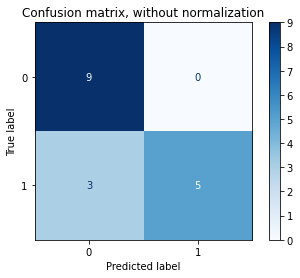

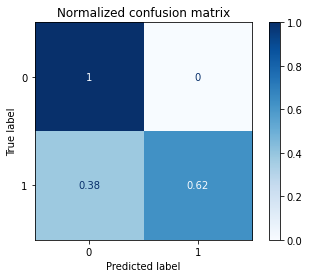

Accuracy score : 0.8235294117647058
Mean accuracy of 5 fold cross validation test : 0.7058823529411764
with a maximum accuracy of 0.7647058823529411
Mean accuracy of 10 fold cross validation test : 0.7444444444444445
with a maximum accuracy of 1.0
Mean accuracy of n fold cross validation test : 0.7058823529411765
with a maximum accuracy of 1.0
Mean accuracy of n fold cross validation test : 0.7176470588235293
with a maximum accuracy of 0.8235294117647058


In [1088]:
classifier = SVC()
testClassifier(classifier,X_train,X_test,y_train,y_test)

Confusion matrix, without normalization
[[9 0]
 [3 5]]
Normalized confusion matrix
[[1.    0.   ]
 [0.375 0.625]]


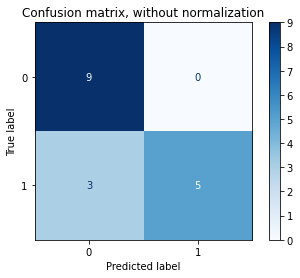

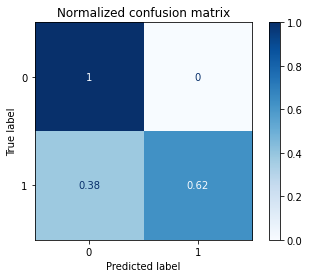

Accuracy score : 0.8235294117647058
Mean accuracy of 5 fold cross validation test : 0.7058823529411764
with a maximum accuracy of 0.7647058823529411
Mean accuracy of 10 fold cross validation test : 0.7444444444444445
with a maximum accuracy of 1.0
Mean accuracy of n fold cross validation test : 0.7058823529411765
with a maximum accuracy of 1.0
Mean accuracy of n fold cross validation test : 0.7176470588235293
with a maximum accuracy of 0.8235294117647058


In [1089]:
classifer = bag_model = BaggingClassifier(
base_estimator = DecisionTreeClassifier(),
n_estimators = 5,
max_samples = 0.7,
oob_score=True,
)
testClassifier(classifier,X_train,X_test,y_train,y_test)

Confusion matrix, without normalization
[[7 2]
 [3 5]]
Normalized confusion matrix
[[0.77777778 0.22222222]
 [0.375      0.625     ]]


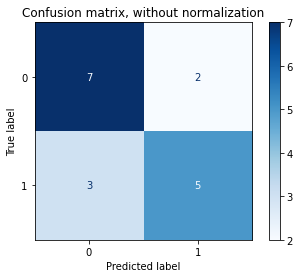

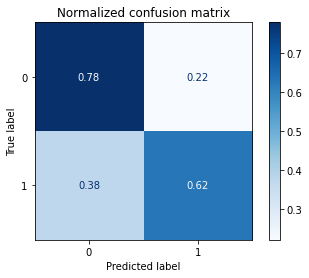

Accuracy score : 0.7058823529411765
Mean accuracy of 5 fold cross validation test : 0.7764705882352941
with a maximum accuracy of 0.8823529411764706
Mean accuracy of 10 fold cross validation test : 0.775
with a maximum accuracy of 1.0
Mean accuracy of n fold cross validation test : 0.7647058823529411
with a maximum accuracy of 1.0
Mean accuracy of n fold cross validation test : 0.7529411764705882
with a maximum accuracy of 0.9411764705882353


In [1090]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

classifier = LDA(n_components=1)
testClassifier(classifier,X_train,X_test,y_train,y_test)

Confusion matrix, without normalization
[[9 0]
 [2 6]]
Normalized confusion matrix
[[1.   0.  ]
 [0.25 0.75]]


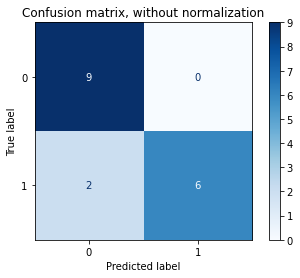

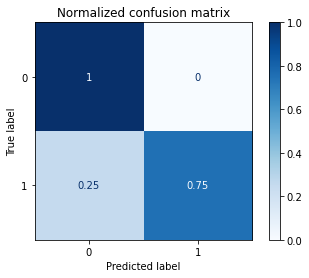

Accuracy score : 0.8823529411764706
Mean accuracy of 5 fold cross validation test : 0.6823529411764706
with a maximum accuracy of 0.8823529411764706
Mean accuracy of 10 fold cross validation test : 0.65
with a maximum accuracy of 1.0
Mean accuracy of n fold cross validation test : 0.6470588235294118
with a maximum accuracy of 1.0
Mean accuracy of n fold cross validation test : 0.6588235294117648
with a maximum accuracy of 0.8823529411764706


In [1091]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
testClassifier(classifier,X_train,X_test,y_train,y_test)

In [1092]:
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import GridSearchCV

# model = SVC()
# model.fit(X_train, y_train)
 
# # print prediction results
# predictions = model.predict(X_test)
# print(classification_report(y_test, predictions))



# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf','linear','poly','sigmoid']}
 
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,cv=5)
 
# # fitting the model for grid search
# grid.fit(X_train, y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


# grid_predictions = grid.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))


In [1093]:
# classifier = KNeighborsClassifier(n_neighbors=10)
# testClassifier(classifier,X_train,X_test,y_train,y_test)

In [1094]:
# from sklearn.ensemble import GradientBoostingClassifier
# classifier = GradientBoostingClassifier()
# classifier.fit(X_test,y_test)
# print(classifier.feature_importances_)
# testClassifier(GradientBoostingClassifier(),X_train,X_test,y_train,y_test)

In [1095]:
# from sklearn.ensemble import GradientBoostingClassifier
# import warnings

# warnings.filterwarnings("ignore")

# param_grid = {'learning_rate': [0.03,0.1,0.3,1,3],
#               'n_estimators': [1,5,10,50,100,200,300,500,1000],
#               'criterion': ['friedman_mse', 'squared_error', 'absolute_error']
#              }
 
# grid = GridSearchCV(GradientBoostingClassifier(), param_grid, refit = True, verbose = 3,cv=5)
# # fitting the model for grid search
# grid.fit(X_train, y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


# grid_predictions = grid.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))


In [1096]:
# import warnings
# param_grid = {'n_neighbors' : [i for i  in range(1,85)]
#              }


# warnings.filterwarnings("ignore")
# grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 1,cv=5)
# # fitting the model for grid search
# grid.fit(X_train, y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


# grid_predictions = grid.best_estimator_.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))


In [1097]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import KFold
# import warnings

# warnings.filterwarnings("ignore")
# # Define a pipeline to search for the best combination of PCA truncation
# # and classifier regularization.
# pca = PCA()
# # Define a Standard Scaler to normalize inputs
# scaler = StandardScaler()
# KnC = KNeighborsClassifier()
# bgclf = BaggingClassifier(base_estimator=KNeighborsClassifier())
# pipe = Pipeline([
#     ('scaler', scaler),
#     ("pca", pca),
#     ('bgclf', bgclf )
# ])
# param_grid = {
#     'pca__n_components' : [6,7],
#     'bgclf__max_samples' : [0.05, 0.1, 0.2,0.7,0.9],
#     'bgclf__warm_start' : [True,False],
#     'bgclf__n_estimators' :  [1,5,10,25,50],
#     'bgclf__base_estimator__n_neighbors' : [1,5,10,15,20]
# }
# grid = GridSearchCV(pipe, param_grid, cv=KFold(68), verbose=1)
# grid.fit(sc.inverse_transform(X_train), y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


# grid_predictions = grid.best_estimator_.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))

In [1098]:
# print(classification_report(y_test, grid_predictions))

In [1099]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import KFold
# import warnings

# warnings.filterwarnings("ignore")
# # Define a pipeline to search for the best combination of PCA truncation
# # and classifier regularization.
# pca = PCA()
# # Define a Standard Scaler to normalize inputs
# scaler = StandardScaler()
# KnC = KNeighborsClassifier()
# bgclf = BaggingClassifier(base_estimator=GaussianNB())
# pipe = Pipeline([
#     ('scaler', scaler),
#     ("pca", pca),
#     ('bgclf', bgclf )
# ])
# param_grid = {
#     'pca__n_components' : [6,7],
#     'bgclf__warm_start' : [True,False],
#     'bgclf__n_estimators' :  [1,5,10,25,50],
#     'bgclf__bootstrap_features': [False, True],
#     'bgclf__max_features': [0.5, 0.7, 1.0],
    
# }
# grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
# grid.fit(sc.inverse_transform(X_train), y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


# grid_predictions = grid.best_estimator_.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))

In [1100]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import KFold
# import warnings

# warnings.filterwarnings("ignore")
# # Define a pipeline to search for the best combination of PCA truncation
# # and classifier regularization.
# pca = PCA()
# # Define a Standard Scaler to normalize inputs
# scaler = StandardScaler()
# KnC = KNeighborsClassifier()
# bgclf = BaggingClassifier(base_estimator=KNeighborsClassifier())
# pipe = Pipeline([
#     ('scaler', scaler),
#     ("pca", pca),
#     ('bgclf', bgclf )
# ])
# param_grid = {
#     'pca__n_components' : [6,7],
#     'bgclf__max_samples' : [0.05, 0.1, 0.2,0.7,0.9,1.0],
#     'bgclf__warm_start' : [True,False],
#     'bgclf__n_estimators' :  [1,5,10,25,50],
#     'bgclf__base_estimator__n_neighbors' : [i for i in range(1,26)]
# }
# grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
# grid.fit(sc.inverse_transform(X_train), y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


# grid_predictions = grid.best_estimator_.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))

In [1101]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import KFold
# import warnings

# warnings.filterwarnings("ignore")
# # Define a pipeline to search for the best combination of PCA truncation
# # and classifier regularization.
# pca = PCA()
# # Define a Standard Scaler to normalize inputs
# scaler = StandardScaler()
# bgclf = BaggingClassifier(base_estimator = DecisionTreeClassifier())
# pipe = Pipeline([
#     ('scaler', scaler),
#     ("pca", pca),
#     ('bgclf', bgclf )
# ])
# param_grid = {
#     'pca__n_components' : [6,7],
#     "bgclf__base_estimator__max_depth": [3,5,10,20],
#     'bgclf__max_samples' : [0.05, 0.1, 0.2,0.7,0.9],
#     'bgclf__warm_start' : [True,False],
#     'bgclf__n_estimators' :  [1,5,10,25,50]
# }
# grid = GridSearchCV(pipe, param_grid, cv=KFold(68), verbose=1)
# grid.fit(sc.inverse_transform(X_train), y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


# grid_predictions = grid.best_estimator_.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))

In [1102]:
# from sklearn.ensemble import GradientBoostingClassifier
# import warnings

# warnings.filterwarnings("ignore")

# pca = PCA()
# # Define a Standard Scaler to normalize inputs
# scaler = StandardScaler()
# gbm = GradientBoostingClassifier()
# pipe = Pipeline([
#     ('scaler', scaler),
#     ("pca", pca),
#     ('gbm', gbm )
# ])
# param_grid = {
#     'pca__n_components' : [5,6,7],
#     'gbm__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2,0.3,0.9,1,1.3,3],
#     'gbm__n_estimators': [1,5,10,15,20,50],
#     'gbm__criterion': ['friedman_mse', 'squared_error']
#              }
 
# grid = GridSearchCV(pipe, param_grid, refit = True, verbose = 0,cv=5)
# # fitting the model for grid search
# grid.fit(sc.inverse_transform(X_train), y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


# grid_predictions = grid.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))

In [1103]:
# from sklearn.ensemble import GradientBoostingClassifier
# import warnings

# warnings.filterwarnings("ignore")

# pca = PCA()
# # Define a Standard Scaler to normalize inputs
# scaler = StandardScaler()
# gbm = GradientBoostingClassifier()
# pipe = Pipeline([
#     ('scaler', scaler),
#     ("pca", pca),
#     ('gbm', gbm )
# ])
# param_grid = {
#     'pca__n_components' : [5,6,7],
#     'gbm__learning_rate': [0.01,0.025,0.05,0.075, 0.1, 0.15, 0.2,0.3,0.9,1,1.3,3],
#     'gbm__n_estimators': [1,5,10,15,20,50,100],
#     'gbm__criterion': ["friedman_mse",'mae','squared_error'],
# }
             
 
# grid = GridSearchCV(pipe, param_grid, refit = True, verbose = 0,cv=10)
# # fitting the model for grid search
# grid.fit(sc.inverse_transform(X_train), y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


# grid_predictions = grid.predict(X_test)
 
# # print classification report
# print(classification_report(y_test, grid_predictions))

In [1104]:
Xy.to_csv('KeyboardData.csv', index=False)


In [1105]:
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y.astype(float),x.astype(float)).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)




In [1106]:
calculate_vif(Xy)

,Var,Vif
0,SDi,23.21
2,InterQuartileRanges,15.37
6,Hist3,9.13
7,Hist4,6.76
3,htArrOutliers,5.24
4,Hist1,4.78
5,Hist2,3.82
9,gt,3.28
1,Dexterity,3.01
8,singularity_spectrum_wdith,2.94


In [1107]:
Xy2 = Xy.drop('InterQuartileRanges',axis=1)

In [1108]:
calculate_vif(Xy2)

,Var,Vif
5,Hist3,9.07
0,SDi,7.58
6,Hist4,6.75
3,Hist1,4.78
2,htArrOutliers,4.12
4,Hist2,3.74
1,Dexterity,3.00
8,gt,2.95
7,singularity_spectrum_wdith,2.93


In [1109]:
Xy2 = Xy.drop('InterQuartileRanges',axis=1)

In [1110]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
cat, num = "gt", "singularity_spectrum_wdith"
model = smf.ols(num+' ~ '+cat, data=Xy2).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Non-Correlated (p-value: 0.054)


In [1111]:
Xy3 = Xy2.drop('htArrOutliers',axis =1)

In [1112]:
calculate_vif(Xy3)

,Var,Vif
4,Hist3,9.01
0,SDi,7.53
5,Hist4,6.74
2,Hist1,3.54
3,Hist2,2.91
7,gt,2.89
1,Dexterity,2.73
6,singularity_spectrum_wdith,2.52


In [1113]:
Xy2.to_csv('KeyboardData2.csv', index=False)

In [1114]:
Xy4 =Xy2.drop('Hist4',axis =1)

In [1115]:
calculate_vif(Xy4)

,Var,Vif
0,SDi,7.50
3,Hist1,4.73
2,htArrOutliers,4.11
4,Hist2,3.62
1,Dexterity,2.97
6,singularity_spectrum_wdith,2.93
7,gt,2.80
5,Hist3,2.29


In [1116]:
Xy4.to_csv('KeyboardData3.csv', index=False)

In [1140]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
data = pd.read_csv("KeyboardData.csv")
X = data.iloc[:,:-1]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=9)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(9,'Score'))  #print 10 best features

                        Specs     Score
2         InterQuartileRanges  0.198360
0                         SDi  0.111266
5                       Hist2  0.057842
1                   Dexterity  0.038005
7                       Hist4  0.004704
3               htArrOutliers  0.000000
4                       Hist1  0.000000
6                       Hist3  0.000000
8  singularity_spectrum_wdith  0.000000


In [1156]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
gbm = GradientBoostingClassifier(n_estimators=100,learning_rate=0.01)
knn = KNeighborsClassifier(n_neighbors=10)
sfs = SequentialFeatureSelector(knn, n_features_to_select=4
                               )
sfs.fit(X, y)
sfs.get_support()

array([ True,  True,  True, False, False, False, False, False,  True])

In [1161]:
de_novo_sick  = de_novo[de_novo['gt']==1]
early_stage_sick = early_stage[early_stage['gt']==1]
de_novo_healthy  = de_novo[de_novo['gt']==0]
early_stage_healthy = early_stage[early_stage['gt']==0]
healthy_controls = pd.concat([early_stage_healthy,de_novo_healthy])
print(healthy_controls['singularity_spectrum_wdith'].mean())
print(early_stage_sick['singularity_spectrum_wdith'].mean())
print(de_novo_sick['singularity_spectrum_wdith'].mean())

0.2272091007414201
0.3229097295803529
0.34935316472727274
